In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import hilbert

# --- JR parameters from literature ---
A, B = 3.25, 22.0      # mV
a, b = 100.0, 50.0     # s^-1
C1, C2, C3, C4 = 135.0, 108.0, 33.75, 33.75
e0, v0, r = 5, 6.0, 0.56

# Sigmoid
def S(v): return 5 / (1.0 + np.exp(r*(v0 - v)))

# JR differential equations for a single region
def jr_rhs(t, y, pP, pE, pI):
    y1, y2, y3, y4, y5, y6 = y
    P, E, I = y1, y3, y5
    d1, d2, d3 = y2, y4, y6

    # Synaptic inputs
    uP = S(E - I) + pP
    uE = C2*S(C1*P) + pE
    uI = C4*S(C3*P) + pI

    dy1 = d1
    dy2 = A*a*uP - 2*a*d1 - a**2*y1
    dy3 = d2
    dy4 = A*a*uE - 2*a*d2 - a**2*y3
    dy5 = d3
    dy6 = B*b*uI - 2*b*d3 - b**2*y5
    return [dy1, dy2, dy3, dy4, dy5, dy6]


In [ ]:
def simulate_jr(pP=0, pE=0, pI=0, T=10.0, dt=1e-4):
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    y0 = 0.1*np.ones(6)
    sol = solve_ivp(jr_rhs, t_span, y0, args=(pP, pE, pI), t_eval=t_eval, rtol=1e-6)
    yP = sol.y[1, int(0.5/dt):]  # drop transient
    amp = np.std(yP)
    return amp

# Sweep each population input
p_values = np.linspace(-100, 400, 500)
amp_P, amp_E, amp_I = [], [], []

for p in p_values:
    amp_P.append(simulate_jr(pP=p, pE=0))
    amp_E.append(simulate_jr(pE=p, pP=0))
    amp_I.append(simulate_jr(pI=p, pP=0))

amp_P, amp_E, amp_I = map(np.array, [amp_P, amp_E, amp_I])


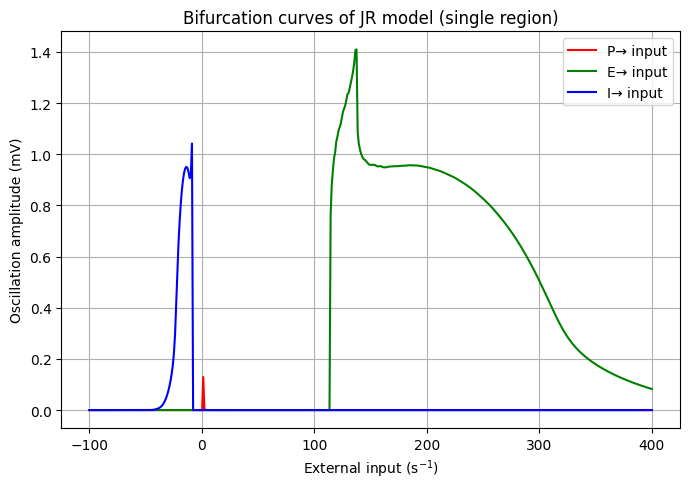

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(p_values, amp_P, 'r-', label='P→ input')
plt.plot(p_values, amp_E, 'g-', label='E→ input')
plt.plot(p_values, amp_I, 'b-', label='I→ input')
plt.xlabel('External input (s$^{-1}$)')
plt.ylabel('Oscillation amplitude (mV)')
plt.title('Bifurcation curves of JR model (single region)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('bifurcation_jr.png', dpi=300)


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

def lyap_max_jr(jr_rhs,               # function(t, y, pP, pE, pI) -> dydt
                pP=120.0, pE=0.0, pI=0.0,
                T=6.0,                # total integration time (s)
                dt=1e-4,              # step for sampling (not the solver's step)
                transient=20.0,        # initial time to discard (s)
                renorm=0.2,           # renormalization interval (s)
                delta0=1e-6,          # initial separation between trajectories
                rtol=1e-7, atol=1e-9, # solver tolerances
                y0=None               # optional initial state (len 6)
               ):
    """
    Estimate the maximal Lyapunov exponent (lambda_max) of the JR ODE by
    evolving two nearby trajectories and periodically renormalizing the separation.

    Returns
    -------
    lambda_max : float
        Estimated maximal Lyapunov exponent (1/s).
        < 0: asymptotically stable; ~0: limit-cycle; > 0: chaotic/unstable.
    """
    # Sampling times (uniform for convenience)
    t_eval = np.arange(0.0, T, dt)

    # Small seeded initial conditions
    if y0 is None:
        y0 = 0.1*np.ones(6)
        #y0[0] = 0.3  # small seed in P to avoid sticking at the fixed point

    # Perturbed initial state
    y0p = y0.copy()
    y0p[0] += delta0

    # Integrate both trajectories
    sol1 = solve_ivp(jr_rhs, (0.0, T), y0,  args=(pP, pE, pI),
                     t_eval=t_eval, rtol=rtol, atol=atol, method='RK45')
    sol2 = solve_ivp(jr_rhs, (0.0, T), y0p, args=(pP, pE, pI),
                     t_eval=t_eval, rtol=rtol, atol=atol, method='RK45')

    if (not sol1.success) or (not sol2.success):
        return np.nan

    # Discard transient
    idx0 = int(transient / dt)
    if idx0 >= len(t_eval) - 2:
        return np.nan
    X1 = sol1.y[:, idx0:]
    X2 = sol2.y[:, idx0:]
    times = sol1.t[idx0:]

    # Renormalize every 'step' samples
    step = max(1, int(renorm / dt))
    d_ref = delta0
    accum_log = 0.0
    count = 0

    # Current separation vector
    v = X2[:, 0] - X1[:, 0]
    dist = np.linalg.norm(v)
    if dist < 1e-16:
        dist = 1e-16

    # Iterate through the sampled times, renormalizing
    for k in range(step, X1.shape[1], step):
        v = X2[:, k] - X1[:, k]
        dist_new = np.linalg.norm(v)
        if dist_new < 1e-16:
            dist_new = 1e-16

        # Accumulate local expansion rate
        accum_log += np.log(dist_new / d_ref)
        count += 1

        # Renormalize perturbed trajectory around the reference
        v_unit = v / dist_new
        X2[:, k:] = X1[:, k:] + (delta0 * v_unit)[:, None]
        d_ref = delta0

    if count == 0:
        return np.nan

    # Average per renorm interval, convert to per-second
    # Each renorm spans approximately 'step * dt' seconds.
    lam = (accum_log / count) * (1.0 / (step * dt))
    return lam


In [ ]:
len(range(-50, 200, 5))

50

In [ ]:
p_values = len(range(-50, 200, 5))
lyap_EI =np.zeros((p_values, p_values))
for i, pE in enumerate(range(-50, 200, 5)):
    for j, pI in enumerate(range(-50, 200, 5)):


        lam = lyap_max_jr(jr_rhs, pP=10.0, pE=pE, pI=pI,
                          T=20.0, dt=1e-4, transient=2.0, renorm=0.2,
                          delta0=.1, rtol=1e-7, atol=1e-9)
        lyap_EI[i, j] = lam

In [ ]:
import pandas as pd
import seaborn as sns
lyap_EI_df = pd.DataFrame(lyap_EI, index=range(-50, 200, 5), columns=range(-50, 200, 5))
lyap_EI_df

,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5,...,150,155,160,165,170,175,180,185,190,195
-50,-1.015666,-1.008703,-1.079260,-1.052509,-0.963784,-1.195589,-0.986811,-0.977580,-1.113304,-1.011960,...,-1.140626,-1.010304,-1.005896,-1.022154,-0.953318,-1.037523,-1.066637,-1.045012,-1.006468,-0.967722
-45,-1.064836,-1.049807,-1.028896,-1.051670,-1.012751,-0.965233,-0.985874,-1.064288,-1.107873,-1.013070,...,-1.012089,-1.026298,-1.018440,-0.998468,-0.982195,-1.079140,-1.086313,-0.999495,-1.048330,-1.098450
-40,-1.029644,-1.149284,-1.016142,-0.983433,-1.006357,-1.000522,-1.197609,-1.041257,-1.017548,-1.082601,...,-1.228531,-1.026876,-1.034807,-1.137611,-0.998494,-1.021606,-0.989042,-0.960406,-0.980918,-1.059182
-35,-1.117205,-0.982173,-1.093804,-1.047274,-0.998755,-1.019069,-0.996240,-0.988937,-1.017627,-0.966410,...,-0.993759,-1.107640,-1.011706,-1.051813,-1.068192,-1.011013,-0.990504,-1.002526,-1.026210,-1.020145
-30,-1.015597,-1.031181,-0.979079,-1.010101,-1.023715,-1.099258,-1.090730,-1.024090,-1.002472,-1.067224,...,-1.038301,-0.988441,-0.982718,-1.013307,-0.987014,-1.099628,-1.059390,-0.996888,-1.048060,-1.033797
-25,-1.007394,-0.998847,-1.099407,-1.003469,-1.081155,-1.106029,-1.179431,-0.989902,-1.047811,-1.003792,...,-1.000982,-1.025281,-0.984410,-1.074544,-0.999587,-1.035745,-1.152514,-0.999014,-0.985106,-1.021384
-20,-0.981830,-0.985524,-1.004704,-1.031949,-1.034019,-0.978704,-1.034536,-1.041159,-1.057480,-1.061379,...,-1.058256,-1.024842,-1.040316,-0.969236,-0.979180,-0.992702,-1.017615,-0.990421,-1.017077,-1.045611
-15,-1.088782,-1.037685,-0.997846,-1.087511,-1.005046,-1.038308,-1.061536,-1.042137,-1.035643,-1.014060,...,-1.055447,-0.985854,-1.073858,-0.990260,-1.055311,-0.989357,-1.020073,-1.052878,-1.018036,-0.992189
-10,-0.997339,-1.160140,-1.036236,-1.025646,-0.980569,-0.985325,-0.989725,-1.002898,-1.037996,-1.027330,...,-1.027348,-0.983061,-0.954464,-1.050484,-0.999221,-1.033588,-0.991466,-1.068140,-1.011499,-1.056020
-5,-1.018414,-1.039848,-1.031916,-1.064897,-0.993360,-1.166366,-0.993334,-1.025764,-1.120006,-0.989665,...,-1.046630,-0.971838,-1.123939,-1.038688,-1.090565,-1.012924,-1.051359,-0.996672,-1.106984,-0.976890


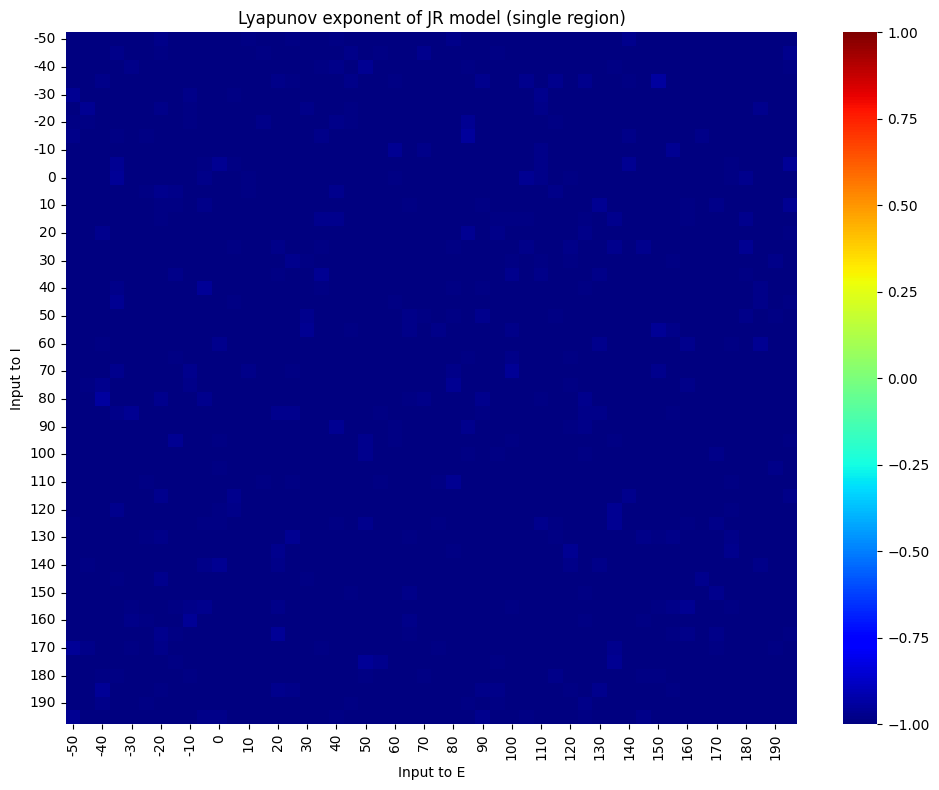

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(lyap_EI_df.T, ax =ax, cmap='jet', vmax=1, vmin=-1)
ax.set_xlabel('Input to E')
ax.set_ylabel('Input to I')
ax.set_title('Lyapunov exponent of JR model (single region)')
plt.tight_layout()


In [ ]:
import numpy as np
from numpy.linalg import qr, norm
from scipy.integrate import solve_ivp

# ---------- JR parameters (you can pass as args if you prefer) ----------
A, B = 3.25, 22.0
a, b = 100.0, 50.0
C1, C2, C3, C4 = 135.0, 108.0, 33.75, 33.75
e0, v0, r = 2.5, 6.0, 0.56

def S(v):
    return e0 / (1.0 + np.exp(r*(v0 - v)))

def dS(v):
    s = S(v)
    # derivative of logistic: s' = r * s * (1 - s/e0)
    return r * s * (1.0 - s / e0)

# ---------- Updated JR RHS ----------
def jr_rhs(t, y, pP, pE, pI):
    y1, y2, y3, y4, y5, y6 = y  # P, dP, E, dE, I, dI
    P, E, I = y1, y3, y5
    d1, d2, d3 = y2, y4, y6

    uP = S(C2*E - C4*I) + pP
    uE = C1*S(P) + pE
    uI = C3*S(P) + pI

    dy1 = d1
    dy2 = A*a*uP  - 2*a*d1 - a*a*y1
    dy3 = d2
    dy4 = A*a*uE  - 2*a*d2 - a*a*y3
    dy5 = d3
    dy6 = B*b*uI  - 2*b*d3 - b*b*y5
    return np.array([dy1, dy2, dy3, dy4, dy5, dy6], dtype=float)

# ---------- Analytic Jacobian J = df/dy (6x6) ----------
def jr_jacobian(y, pP, pE, pI):
    y1, y2, y3, y4, y5, y6 = y
    P, E, I = y1, y3, y5

    # helpful terms
    dS_PE = dS(C2*E - C4*I)  # derivative inside uP wrt (C2*E - C4*I)
    dS_P  = dS(P)            # derivative S(P)

    J = np.zeros((6,6), dtype=float)

    # dy1 = d1
    J[0,1] = 1.0

    # dy2 = A a^2 uP - 2 a d1 - a^2 y1
    J[1,0] = -a*a                  # ∂/∂y1
    J[1,1] = -2*a                  # ∂/∂y2
    J[1,2] =  A*a * dS_PE * C2   # ∂uP/∂E * A a^2
    J[1,4] =  A*a * dS_PE * (-C4)# ∂uP/∂I * A a^2

    # dy3 = d2
    J[2,3] = 1.0

    # dy4 = A a^2 uE - 2 a d2 - a^2 y3,  uE = C1 S(P) + pE
    J[3,0] = A*a * C1 * dS_P     # via S'(P)
    J[3,2] = -a*a
    J[3,3] = -2*a

    # dy5 = d3
    J[4,5] = 1.0

    # dy6 = B b^2 uI - 2 b d3 - b^2 y5, uI = C3 S(P) + pI
    J[5,0] = B*b * C3 * dS_P
    J[5,4] = -b*b
    J[5,5] = -2*b

    return J

# ---------- Full Lyapunov spectrum (Benettin QR) + per-state weights ----------
def lyapunov_spectrum_jr(pP=120.0, pE=0.0, pI=0.0,
                         T=12.0, dt=1e-4, transient=2.0, renorm=0.2,
                         y0=None, rtol=1e-7, atol=1e-9, seed=0):
    """
    Returns:
      lambdas : (6,) Lyapunov exponents (1/s), sorted descending
      weights_avg : (6,) average squared component of the *dominant* Lyapunov vector
                    on each state [P, dP, E, dE, I, dI] over time (sums to ~1)
    """
    rng = np.random.default_rng(seed)
    n = 6
    t_eval = np.arange(0.0, T, dt)

    if y0 is None:
        y0 = np.zeros(n); y0[0] = 0.3

    # Reference trajectory
    sol = solve_ivp(lambda t,y: jr_rhs(t,y,pP,pE,pI), (0.0, T), y0,
                    t_eval=t_eval, rtol=rtol, atol=atol, method='RK45')
    if not sol.success:
        return np.full(n, np.nan), np.full(n, np.nan)

    # Discard transient
    k0 = int(transient/dt)
    X = sol.y[:, k0:]
    times = sol.t[k0:]
    m = X.shape[1]
    if m < 5:
        return np.full(n, np.nan), np.full(n, np.nan)

    # Initialize tangent matrix (orthonormal)
    Q = rng.normal(size=(n, n))
    Q, _ = qr(Q)  # orthonormal basis
    sum_log = np.zeros(n)

    # storage for dominant vector components (first column of Q) for averaging
    comp_accum = np.zeros(n)
    comp_count = 0

    # step between re-orthonormalizations (in samples)
    step = max(1, int(renorm/dt))

    # March along trajectory, evolving tangent basis with local Jacobian
    for k in range(0, m-1):
        yk = X[:, k]
        J = jr_jacobian(yk, pP, pE, pI)

        # simple Euler for tangent evolution over one sample interval
        # (works because dt is small and we QR frequently)
        Q = Q + dt * (J @ Q)

        # Renormalize every 'step' samples
        if (k+1) % step == 0:
            Q, R = qr(Q)     # QR re-orthonormalization
            diagR = np.diag(R)
            # prevent log(0)
            diagR = np.where(np.abs(diagR) < 1e-16, 1e-16, np.abs(diagR))
            sum_log += np.log(diagR)

            # dominant direction = first column of Q
            v1 = Q[:, 0]
            comp_accum += (v1**2)
            comp_count += 1

    # convert to per-second exponents
    total_time = (m-1) * dt
    intervals = (m-1) // step
    if intervals == 0 or total_time <= 0:
        return np.full(n, np.nan), np.full(n, np.nan)

    lambdas = (sum_log / intervals) * (1.0 / (step*dt))

    # Sort descending and reorder component weights accordingly
    idx = np.argsort(lambdas)[::-1]
    lambdas = lambdas[idx]

    # Average component weights of dominant vector (as reported at QR times)
    if comp_count > 0:
        weights = comp_accum / comp_count
        weights /= weights.sum() if weights.sum() > 0 else 1.0
    else:
        weights = np.full(n, np.nan)

    # weights correspond to the dominant column during the run (pre-sort).
    # After sorting, dominant exponent is lambdas[0]. The weights we tracked
    # already correspond to that direction (first column during QR), so we return them as-is.
    return lambdas, weights

# -------- Example usage ----------
if __name__ == "__main__":
    lambdas, w = lyapunov_spectrum_jr(pP=100.0, pE=20.0, pI=40.0,
                                      T=50.0, dt=1e-4, transient=2.0, renorm=0.2)
    print("Lyapunov spectrum (1/s):", lambdas)      # λ1 ≥ λ2 ≥ ... ≥ λ6
    print("Dominant vector component weights [P,dP,E,dE,I,dI]:", w)


Lyapunov spectrum (1/s): [ -49.88832745  -50.28506684 -100.01214811 -100.48422873 -100.546054
 -101.04843382]
Dominant vector component weights [P,dP,E,dE,I,dI]: [7.96332012e-17 7.22666401e-13 1.91670136e-13 1.30297458e-09
 4.01985280e-04 9.99598013e-01]


In [ ]:
def simulate_jr(pP=0, pE=110, pI=0, T=40.0, dt=1e-4):
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    y0 = 0.1*np.ones(6)
    y0[4] = 0.12
    sol = solve_ivp(jr_rhs, t_span, y0, args=(pP, pE, pI), t_eval=t_eval, rtol=1e-6)
    P = sol.y[0, int(0.5/dt):]  # drop transient
    E = sol.y[2, int(0.5/dt):]
    I = sol.y[4, int(0.5/dt):]
    #amp = np.std(yP)
    return P, E, I

In [ ]:
P_sim, E_sim, I_sim = simulate_jr(pP=1, pE =46)

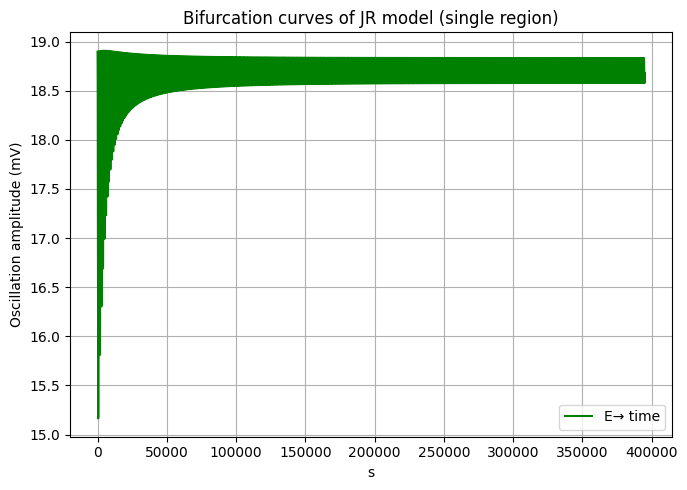

In [ ]:
plt.figure(figsize=(7,5))
#plt.plot(P_sim, 'r-', label='P→ time')
plt.plot(E_sim, 'g-', label='E→ time')
#plt.plot(I_sim, 'b-', label='I→ input')
plt.xlabel('s')
plt.ylabel('Oscillation amplitude (mV)')
plt.title('Bifurcation curves of JR model (single region)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# df should have columns: ['param','run','true','mean','sd','ci_lo','ci_hi']
def summarize_recovery(df):
    rows = []
    for p, g in df.groupby('param'):
        true = np.unique(g['true'])[0]
        est  = g['mean'].values
        sd   = g['sd'].values
        bias = np.mean((est-true)/true)*100.0
        nrmse = (np.sqrt(np.mean((est-true)**2))/abs(true))*100.0
        cover = np.mean((g['ci_lo'].values <= true) & (true <= g['ci_hi'].values))*100.0
        # calibration slope: reg of |est-true| on sd (robust median ratio)
        slope = np.median(np.abs(est-true)/ (sd + 1e-12))
        # ICC(1): between-run reliability (one-way random)
        # ICC ≈ (MS_between - MS_within) / (MS_between + (k-1)*MS_within)
        # here k = number of repeats per synthetic set; fallback use var decomposition across runs
        msw = np.mean((est - np.mean(est))**2)  # proxy if sets not labeled
        msb = np.var([np.mean(est)], ddof=1) if len(est)>1 else 0.0
        icc = (msb - msw) / (msb + (len(est)-1)*msw) if len(est)>1 else np.nan
        rows.append(dict(param=p, true=true, mean=np.mean(est), sd=np.std(est),
                         bias_pct=bias, nrmse_pct=nrmse, cover95_pct=cover,
                         calib_slope=slope, icc=icc))
    return pd.DataFrame(rows)


In [ ]:
import numpy as np

# y[t, region, state_idx]  -> shape [T, N, 6]  (P, dP, E, dE, I, dI)
# assume mean-subtracted
def compute_biomarkers(y, lam_max):
    P, E, I = y[...,0], y[...,2], y[...,4]
    # (i) E/I balance of state variance
    eib_state = np.var(E, axis=0) / np.var(I, axis=0)
    # (ii) criticality distance from Lyapunov
    xi = -np.mean(lam_max, axis=0)
    # (iii) sensitivity (finite difference or correlation-based proxy)
    sE = np.array([np.corrcoef(P[:,j], E[:,j])[0,1] for j in range(y.shape[1])])
    sI = np.array([np.corrcoef(P[:,j], I[:,j])[0,1] for j in range(y.shape[1])])
    deltaS = sE - sI
    return eib_state, xi, deltaS

In [ ]:
import numpy as np
import pandas as pd

# --- robust linear fit (falls back to numpy if sklearn not available) ---
def _robust_linfit(x, y):
    try:
        from sklearn.linear_model import HuberRegressor
        m = HuberRegressor().fit(x.reshape(-1,1), y)
        slope = float(m.coef_[0]); intercept = float(m.intercept_)
        yhat = m.predict(x.reshape(-1,1))
    except Exception:
        # OLS fallback
        A = np.vstack([x, np.ones_like(x)]).T
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        yhat = A @ np.array([slope, intercept])
    # R^2
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2) + 1e-12
    r2 = 1 - ss_res/ss_tot
    return slope, intercept, r2

def _rolling_mu_sigma(x, L, S):
    W = max(0, (len(x) - L) // S + 1)
    mu = np.empty(W); sd = np.empty(W); rho1 = np.empty(W)
    for w in range(W):
        seg = x[w*S : w*S + L]
        seg = seg - seg.mean()
        mu[w] = seg.mean() + 0.0  # (mean after detrend is ~0; keep for generality)
        sd[w] = seg.std(ddof=1)
        # lag-1 autocorr
        s0, s1 = seg[:-1], seg[1:]
        num = np.dot(s0, s1)
        den = np.sqrt(np.dot(s0, s0) * np.dot(s1, s1)) + 1e-12
        rho1[w] = np.clip(num/den, -0.999, 0.999)
    return mu, sd, rho1

def _corr_time_from_rho1(rho1, dt):
    tau_c = np.zeros_like(rho1)
    pos = rho1 > 0
    tau_c[pos] = -dt / np.log(rho1[pos] + 1e-12)
    return tau_c

def mean_var_slope_metrics(E, fs, win_sec=1.0, step_sec=0.2):
    """
    E: np.ndarray shape [T, R] (time x regions), excitatory population
    fs: sampling rate (Hz)
    Returns:
      region_df: per-region metrics
    """
    T, R = E.shape
    L = int(round(win_sec*fs))
    S = int(round(step_sec*fs))
    if L < 10: raise ValueError("win_sec too small for the sampling rate.")
    out = []
    for j in range(R):
        x = np.asarray(E[:, j]).astype(float)
        mu, sd, rho1 = _rolling_mu_sigma(x, L, S)
        if len(mu) < 5:
            out.append(dict(region=j, slope_mu_sd=np.nan, r2_mu_sd=np.nan,
                            slope_cv_mu=np.nan, rho1_mean=np.nan, tau_c_mean=np.nan))
            continue
        # slope of sigma vs mu
        s1, b1, r2_1 = _robust_linfit(mu, sd)
        # CV trend vs mu
        cv = sd / (np.abs(mu) + 1e-12)
        s_cv, b_cv, r2_cv = _robust_linfit(mu, cv)
        # lag-1 and correlation time
        tau_c = _corr_time_from_rho1(rho1, 1.0/fs)
        out.append(dict(region=j,
                        slope_mu_sd=s1, r2_mu_sd=r2_1,
                        slope_cv_mu=s_cv, r2_cv_mu=r2_cv,
                        rho1_mean=float(np.nanmean(rho1)),
                        tau_c_mean=float(np.nanmean(tau_c)),
                        n_windows=len(mu)))
    region_df = pd.DataFrame(out)
    return region_df

def summarize_by_network(region_df, net_ids, n_boot=2000, seed=0):
    """
    net_ids: array-like length R with integer or string network labels per region
    Returns net_df with mean and 95% CI from bootstrap across regions.
    """
    rng = np.random.default_rng(seed)
    df = region_df.copy()
    df['network'] = np.asarray(net_ids)
    metrics = ['slope_mu_sd','r2_mu_sd','slope_cv_mu','r2_cv_mu','rho1_mean','tau_c_mean']
    rows = []
    for net, sub in df.groupby('network'):
        row = {'network': net, 'n_regions': len(sub)}
        for m in metrics:
            vals = sub[m].values.astype(float)
            row[f'{m}_mean'] = float(np.nanmean(vals))
            # bootstrap CI over regions
            bs = []
            for _ in range(n_boot):
                idx = rng.integers(0, len(vals), len(vals))
                bs.append(np.nanmean(vals[idx]))
            lo, hi = np.nanpercentile(bs, [2.5, 97.5])
            row[f'{m}_ci95_lo'] = float(lo)
            row[f'{m}_ci95_hi'] = float(hi)
        rows.append(row)
    net_df = pd.DataFrame(rows)
    return net_df


In [ ]:
import numpy as np
import pandas as pd

# --- robust linear fit (falls back to numpy if sklearn not available) ---
def _robust_linfit(x, y):
    try:
        from sklearn.linear_model import HuberRegressor
        m = HuberRegressor().fit(x.reshape(-1,1), y)
        slope = float(m.coef_[0]); intercept = float(m.intercept_)
        yhat = m.predict(x.reshape(-1,1))
    except Exception:
        # OLS fallback
        A = np.vstack([x, np.ones_like(x)]).T
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        yhat = A @ np.array([slope, intercept])
    # R^2
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - y.mean())**2) + 1e-12
    r2 = 1 - ss_res/ss_tot
    return slope, intercept, r2

def _rolling_mu_sigma(x, L, S):
    W = max(0, (len(x) - L) // S + 1)
    mu = np.empty(W); sd = np.empty(W); rho1 = np.empty(W)
    for w in range(W):
        seg = x[w*S : w*S + L]
        seg = seg - seg.mean()
        mu[w] = seg.mean() + 0.0  # (mean after detrend is ~0; keep for generality)
        sd[w] = seg.std(ddof=1)
        # lag-1 autocorr
        s0, s1 = seg[:-1], seg[1:]
        num = np.dot(s0, s1)
        den = np.sqrt(np.dot(s0, s0) * np.dot(s1, s1)) + 1e-12
        rho1[w] = np.clip(num/den, -0.999, 0.999)
    return mu, sd, rho1

def _corr_time_from_rho1(rho1, dt):
    tau_c = np.zeros_like(rho1)
    pos = rho1 > 0
    tau_c[pos] = -dt / np.log(rho1[pos] + 1e-12)
    return tau_c

def mean_var_slope_metrics(E, fs, win_sec=1.0, step_sec=0.2):
    """
    E: np.ndarray shape [T, R] (time x regions), excitatory population
    fs: sampling rate (Hz)
    Returns:
      region_df: per-region metrics
    """
    T, R = E.shape
    L = int(round(win_sec*fs))
    S = int(round(step_sec*fs))
    if L < 10: raise ValueError("win_sec too small for the sampling rate.")
    out = []
    for j in range(R):
        x = np.asarray(E[:, j]).astype(float)
        mu, sd, rho1 = _rolling_mu_sigma(x, L, S)
        if len(mu) < 5:
            out.append(dict(region=j, slope_mu_sd=np.nan, r2_mu_sd=np.nan,
                            slope_cv_mu=np.nan, rho1_mean=np.nan, tau_c_mean=np.nan))
            continue
        # slope of sigma vs mu
        s1, b1, r2_1 = _robust_linfit(mu, sd)
        # CV trend vs mu
        cv = sd / (np.abs(mu) + 1e-12)
        s_cv, b_cv, r2_cv = _robust_linfit(mu, cv)
        # lag-1 and correlation time
        tau_c = _corr_time_from_rho1(rho1, 1.0/fs)
        out.append(dict(region=j,
                        slope_mu_sd=s1, r2_mu_sd=r2_1,
                        slope_cv_mu=s_cv, r2_cv_mu=r2_cv,
                        rho1_mean=float(np.nanmean(rho1)),
                        tau_c_mean=float(np.nanmean(tau_c)),
                        n_windows=len(mu)))
    region_df = pd.DataFrame(out)
    return region_df

def summarize_by_network(region_df, net_ids, n_boot=2000, seed=0):
    """
    net_ids: array-like length R with integer or string network labels per region
    Returns net_df with mean and 95% CI from bootstrap across regions.
    """
    rng = np.random.default_rng(seed)
    df = region_df.copy()
    df['network'] = np.asarray(net_ids)
    metrics = ['slope_mu_sd','r2_mu_sd','slope_cv_mu','r2_cv_mu','rho1_mean','tau_c_mean']
    rows = []
    for net, sub in df.groupby('network'):
        row = {'network': net, 'n_regions': len(sub)}
        for m in metrics:
            vals = sub[m].values.astype(float)
            row[f'{m}_mean'] = float(np.nanmean(vals))
            # bootstrap CI over regions
            bs = []
            for _ in range(n_boot):
                idx = rng.integers(0, len(vals), len(vals))
                bs.append(np.nanmean(vals[idx]))
            lo, hi = np.nanpercentile(bs, [2.5, 97.5])
            row[f'{m}_ci95_lo'] = float(lo)
            row[f'{m}_ci95_hi'] = float(hi)
        rows.append(row)
    net_df = pd.DataFrame(rows)
    return net_df


In [ ]:
# E: (T, 200) array of excitatory time series; fs in Hz
region_df = mean_var_slope_metrics(E, fs=1000, win_sec=1.5, step_sec=0.25)

# If you have network labels for the 200 regions (e.g., Yeo-7):
# net_ids: length-200 array like [1,1,2,2,3,...]
net_df = summarize_by_network(region_df, net_ids)

print(region_df.head())
print(net_df[['network','slope_mu_sd_mean','slope_mu_sd_ci95_lo','slope_mu_sd_ci95_hi']])


In [1]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Mounted at /content/drive


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from PIL import Image

# 1) Load the 80-run recovery CSV
df = pd.read_csv("/content/drive/MyDrive/Work/Sciencing/Data/criticality_states_JR.csv")   # <- adjust path if needed

# --- Chart A: β (slope) distributions (overlayed histograms) ---
plt.figure(figsize=(6,4), dpi=150)
plt.hist(df["p_beta"], bins=12, alpha=0.6, label="P (β)", edgecolor='black')
plt.hist(df["e_beta"], bins=12, alpha=0.6, label="E (β)", edgecolor='black')
plt.hist(df["i_beta"], bins=12, alpha=0.6, label="I (β)", edgecolor='black')
plt.xlabel("Mean–variance slope (β)")
plt.ylabel("Count")
plt.title("Recovery across 80 re-fits: β distributions")
plt.legend(frameon=False)
beta_path = "/content/drive/MyDrive/Work/Sciencing/Data/beta_distributions.png"
plt.tight_layout(); plt.savefig(beta_path, bbox_inches="tight"); plt.close()

# --- Chart B: τ̄ (mean correlation time) distributions ---
plt.figure(figsize=(6,4), dpi=150)
plt.hist(df["p_tau_mean"], bins=12, alpha=0.6, label="P (τ̄)", edgecolor='black')
plt.hist(df["e_tau_mean"], bins=12, alpha=0.6, label="E (τ̄)", edgecolor='black')
plt.hist(df["i_tau_mean"], bins=12, alpha=0.6, label="I (τ̄)", edgecolor='black')
plt.xlabel("Mean correlation time (τ̄, s)")
plt.ylabel("Count")
plt.title("Recovery across 80 re-fits: τ̄ distributions")
plt.legend(frameon=False)
tau_path = "/content/drive/MyDrive/Work/Sciencing/Data/tau_distributions.png"
plt.tight_layout(); plt.savefig(tau_path, bbox_inches="tight"); plt.close()

# --- Chart C: β–τ̄ coupling (one scatter, 3 populations; with simple fits) ---
plt.figure(figsize=(6,4), dpi=150)
plt.scatter(df["p_beta"], df["p_tau_mean"], alpha=0.7, label="P")
plt.scatter(df["e_beta"], df["e_tau_mean"], alpha=0.7, label="E")
plt.scatter(df["i_beta"], df["i_tau_mean"], alpha=0.7, label="I")
for pop in ['p','e','i']:
    x, y = df[f"{pop}_beta"].values, df[f"{pop}_tau_mean"].values
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs + b, linewidth=1)
plt.xlabel("Mean–variance slope (β)")
plt.ylabel("Mean correlation time (τ̄, s)")
plt.title("β–τ̄ coupling across 80 re-fits")
plt.legend(frameon=False)
corr_path = "/content/drive/MyDrive/Work/Sciencing/Data/beta_tau_correlation.png"
plt.tight_layout(); plt.savefig(corr_path, bbox_inches="tight"); plt.close()

# --- Combine into one “summary” image (no subplots; post-stitched) ---
imgs = [Image.open(p) for p in [beta_path, tau_path, corr_path]]
h = max(im.height for im in imgs)
imgs = [im.resize((int(im.width*(h/im.height)), h)) for im in imgs]
gutter = 20
from PIL import Image as PILImage
summary = PILImage.new("RGB", (sum(im.width for im in imgs)+gutter*2, h), (255,255,255))
x = 0
for i, im in enumerate(imgs):
    summary.paste(im, (x, 0))
    x += im.width + (gutter if i < len(imgs)-1 else 0)
summary_path = "/content/drive/MyDrive/Work/Sciencing/Data/recovery_beta_tau_summary.png"
summary.save(summary_path)

print("Saved:")
print(beta_path)
print(tau_path)
print(corr_path)
print(summary_path)


Saved:
/content/drive/MyDrive/Work/Sciencing/Data/beta_distributions.png
/content/drive/MyDrive/Work/Sciencing/Data/tau_distributions.png
/content/drive/MyDrive/Work/Sciencing/Data/beta_tau_correlation.png
/content/drive/MyDrive/Work/Sciencing/Data/recovery_beta_tau_summary.png
